In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import numpy as np
import glob
import pandas as pd
import mygene
import os
from functools import reduce
from sequencing_tools.viz_tools import simpsons_palette
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
from plotting_utils import *
from functools import lru_cache
from kallisto_plots import plot_heatmap, TOP_RNA, \
                    read_kallisto, published, label_gene,\
                    gene_cats, gene_encoder, genes_annot
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-2222...done.
Finished.
25 input query terms found no hit:
	['NM_201633', 'NM_007273', 'NM_012103', 'NM_181576', 'NM_016015', 'NM_016534', 'NM_018579', 'NM_0188
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [3]:
salmon_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/kallisto_protein_result'
sample_folders = glob.glob(salmon_path + '/*')

sample_folders.sort()
kallisto_tpm = list(map(lambda x: x + '/abundance.tsv', sample_folders))
tpm_dfs = map(read_kallisto, kallisto_tpm)
tpm_dfs = map(lambda d: d.drop(['eff_length'], axis=1), tpm_dfs)
tpm_df = reduce(lambda x,y: x.merge(y, how = 'outer', on = ['gname','gid']), tpm_dfs) \
    .pipe(pd.melt, id_vars = ['gname','gid'], var_name ='samplename', value_name = 'TPM') \
    .assign(prep = lambda d: d.samplename.map(label_sample)) \
    .groupby(['gname','gid','prep'], as_index=False)\
    .agg({'TPM': 'mean'}) \
    .assign(TPM = lambda d: d.groupby('prep')['TPM'].transform(lambda x: x/x.sum() * 1e6))\
    .pipe(pd.pivot_table, columns = 'prep', values='TPM', index=['gid','gname'], fill_value = 0)\
    .reset_index()
tpm_df.head()

prep,gid,gname,DNase I,DNase I + Exo I,DNase I - 3'P,Fragmented,Poly(A)-selected
0,ENSG00000000003.14_2,TSPAN6,21.457791,5.625766,20.553234,20.707060,0.830913
1,ENSG00000000005.5_2,TNMD,0.000000,119.215329,57.924334,26.024160,0.668265
2,ENSG00000000419.12_2,DPM1,0.000000,0.000000,35.865567,16.770300,19.961840
3,ENSG00000000457.13_3,SCYL3,20.041908,0.000000,27.021931,12.108418,0.536050
4,ENSG00000000460.16_5,C1orf112,0.000000,10.849366,4.214533,8.718532,3.550485


In [ ]:
def cor_ntile(d):
    x = np.log(d['bone marrow']+1)
    y = np.log(d['Poly(A)-selected']+1)
    spearman_r, _ = spearmanr(x, y)
    pearson_r, _ = pearsonr(x, y)
    cosine_sim = cosine_similarity(x.values.reshape(1,-1), y.values.reshape(1,-1))
    #cor_coef = d.filter(regex = 'bone|Qc').corr(method='spearman')
    #cor_coef = cor_coef.iloc[0,1]
    return pd.DataFrame({'ntile':[d.ntile.unique()[0]],
                        "Spearman's\ncorrelation":[spearman_r],
                         "Pearson's\ncorrelation":[pearson_r],
                        'Cosine\nsimilarity':[cosine_sim[0][0]]})


merged_df = tpm_df\
    .merge(read_kallisto(kallisto_tpm[0]).filter(regex = 'gid|gname|eff_length'), on = ['gid','gname'])\
    .assign(ntile = lambda d: pd.qcut(d['eff_length'],10, labels=False))  \
    .assign(Gene = lambda d: d.gid.str.split('.', expand=True).iloc[:,0])\
    .merge(published(), on = 'Gene') \
    
qcut_df = merged_df\
    .groupby('ntile', as_index=False)\
    .apply(cor_ntile) \
    .assign(ntile = lambda d: 'Quantile group: ' + d.ntile.transform(lambda x: x+1).astype(str))
qcut_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


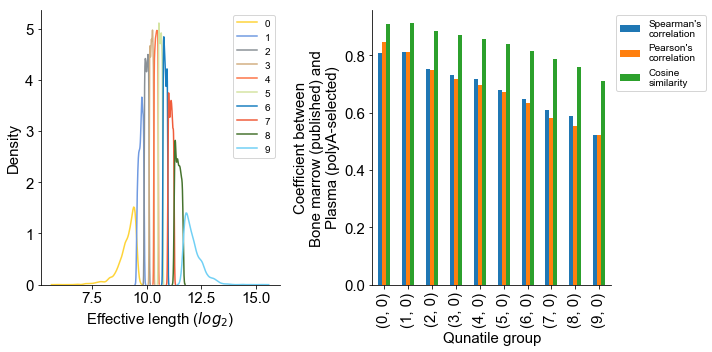

In [79]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)


colors = simpsons_palette()
for col, (gl, gl_df) in zip(colors, merged_df.groupby('ntile')):
    sns.distplot(np.log2(gl_df['eff_length']), 
                 ax = ax, 
                 color = col,
                 label = gl,
                hist=False)
ax.set_xlabel('Effective length ($log_2$)')
ax.set_ylabel('Density')




ax = fig.add_subplot(122)
qcut_df.plot.bar(ax = ax)
ax.legend(bbox_to_anchor = (1,1))#.set_visible(False)
ax.set_xlabel('Qunatile group')
ax.set_ylabel(r"Coefficient"\
    ' between\nBone marrow (published) and\nPlasma (polyA-selected)')
sns.despine()
fig.tight_layout()
fig.savefig(figure_path + '/salmon_similarity.pdf')

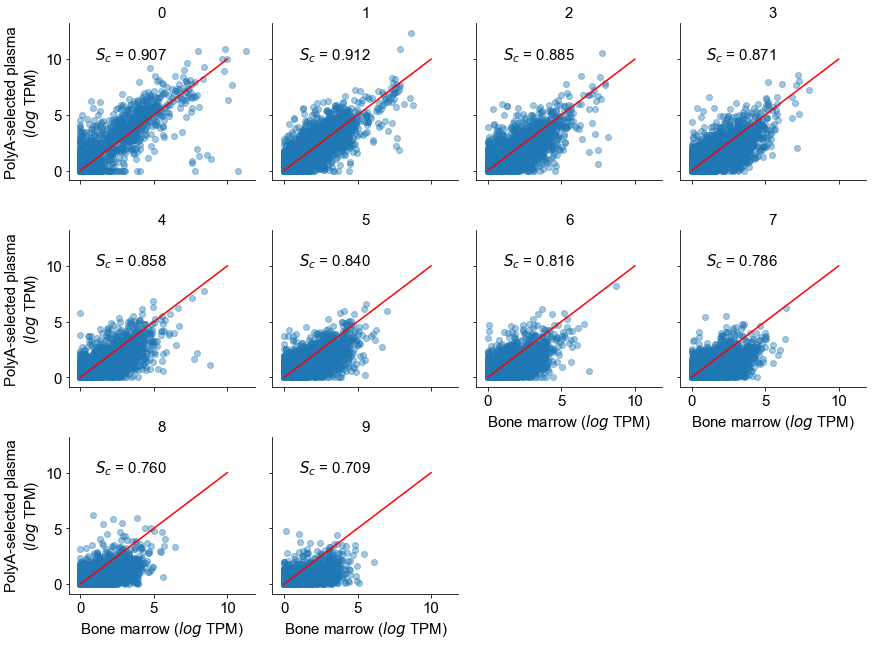

In [80]:
from scipy.stats import pearsonr

plot_qcut = merged_df\
                      .assign(plasma = lambda d: d['Poly(A)-selected'].transform(lambda x: np.log(x+1)))\
                      .assign(bone = lambda d: d['bone marrow'].transform(lambda x: np.log(x+1)))\
                      .sort_values('ntile')
p = sns.FacetGrid(data = plot_qcut, 
                  col = 'ntile', col_wrap = 4)
p.map(plt.scatter, 'bone', 'plasma', alpha=0.4)
p.set_titles('{col_name}')
p.set_axis_labels('Bone marrow ($log$ TPM)', 'PolyA-selected plasma\n($log$ TPM)')

for ax in p.fig.axes:
    ax.plot([0,10],[0,10], color='red')
    
    data = plot_qcut.query("ntile == '%s'" %(ax.title.get_text()))
    cor_coef  = cosine_similarity(data['plasma'].values.reshape(1, -1), 
                                  data['bone'].values.reshape(1, -1))
    ax.text(1, 10, '$S_c$ = %.3f' %cor_coef, fontsize=15)
#ax.set_xscale('log')
#ax.set_yscale('log')
fig.tight_layout()
fig.savefig(figure_path + '/salmon_scatter_similarity.pdf')

In [81]:
gene_df = tpm_df \
    .assign(gene_label = lambda d: d.gname.map(label_gene))\
    .assign(top = lambda d: np.where(d.gname.isin(TOP_RNA), 'is_top','not_top'))\
    .assign(gene_label = lambda d: np.where(d.top=='is_top', "5' TOP", d.gene_label))\
    .assign(gene_label = lambda d: d.gene_label.astype(pd.api.types\
                                .CategoricalDtype(gene_cats)))\
    .assign(color = lambda d: d.gene_label.map(gene_encoder.encoder))
gene_df.head()

prep,gid,gname,DNase I,DNase I + Exo I,DNase I + Phosphatase,Fragmented,Poly(A)-selected,gene_label,top,color
0,ENSG00000000003.14_2,TSPAN6,21.457791,5.625766,20.553234,20.707060,0.830913,Others,not_top,grey
1,ENSG00000000005.5_2,TNMD,0.000000,119.215329,57.924334,26.024160,0.668265,Others,not_top,grey
2,ENSG00000000419.12_2,DPM1,0.000000,0.000000,35.865567,16.770300,19.961840,Others,not_top,grey
3,ENSG00000000457.13_3,SCYL3,20.041908,0.000000,27.021931,12.108418,0.536050,Others,not_top,grey
4,ENSG00000000460.16_5,C1orf112,0.000000,10.849366,4.214533,8.718532,3.550485,Others,not_top,grey


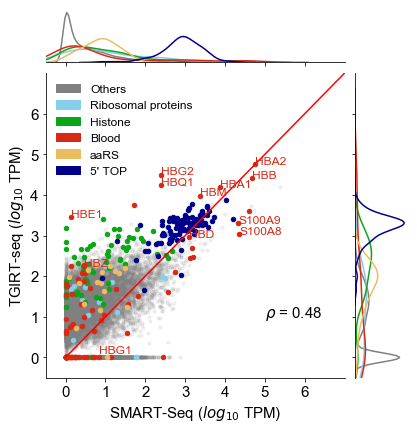

In [93]:
xn = 'Poly(A)-selected'
yn = 'DNase I'
#xn = 'DNase I + Phosphatase'
p = sns.JointGrid(data = gene_df, 
                  x = xn, 
                  y = yn)    
for (gt, col), gt_df in gene_df.groupby(['gene_label','color']):
    xv = np.log10(gt_df[xn]+1)
    yv = np.log10(gt_df[yn]+1)
    
    alpha = 0.1 if gt == 'Others' else 1
    size = 10 if gt == 'Others' else 20
    p.ax_joint.scatter(xv, 
                       yv, 
                       s = size,
                       color = col, 
                       alpha = alpha)
    sns.distplot(xv, ax = p.ax_marg_x, color = col, hist=False)
    sns.distplot(yv, ax = p.ax_marg_y, color = col, hist=False, vertical=True)
    p.ax_marg_x.set_xlabel('')
    p.ax_marg_y.set_ylabel('')
    
    if gt == 'Blood':
        for i, row in gt_df.pipe(lambda d: d[d.gname.str.contains('^HB|^S100A[89]')]).iterrows():
            offset = 0.1 if row['gname'] == 'HBG1' else 0
            p.ax_joint.text(np.log10(row[xn]+1), 
                            np.log10(row[yn]+1)+offset, 
                           row['gname'], fontsize=12, color = gene_encoder.encoder['Blood'])

lgd = gene_encoder.show_legend(p.ax_joint, loc = 'upper left', frameon=False, fontsize=12)
lgd.set_title(title = '', prop={'size':12})
p.ax_joint.set_xlabel('SMART-Seq ($log_{10}$ TPM)')
p.ax_joint.set_ylabel('TGIRT-seq ($log_{10}$ TPM)')

r, _ = spearmanr(np.log10(gene_df[xn]+1), np.log10(gene_df[yn]+1))
p.ax_joint.text(5,1, r'$\rho$ = %.2f' %(r), fontsize=15)
#p.ax_marg_y.set_visible(False)
#p.ax_marg_x.set_visible(False)

p.ax_marg_y.set_ylim(0,7)
p.ax_marg_x.set_xlim(0,7)
p.ax_joint.set_xlim(-0.5,7)
p.ax_joint.set_ylim(-0.5,7)

p.ax_joint.set_xticks(np.arange(-0,7,1))
p.ax_joint.set_yticks(np.arange(-0,7,1))
p.ax_joint.plot([0,7],[0,7], color='red')
p.savefig(figure_path + '/kallisto_protein_scatter.pdf', bbox_inches='tight')
p.savefig(figure_path + '/kallist_protein_scatter.png', bbox_inches='tight')

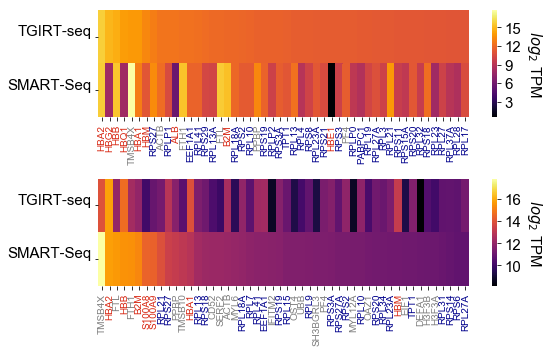

In [83]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(211)
plot_heatmap(tpm_df, ax , 'DNase I', selected='Poly|DNase I$', colored=True)
#ge.show_legend(ax, bbox_to_anchor = (-0.4,0.7), fontsize=15)
ax.set_ylabel('')
ax.set_xlabel('')

ax = fig.add_subplot(212)
plot_heatmap(tpm_df, ax , 'Poly(A)-selected', selected='Poly|DNase I$', colored=True)
ax.set_ylabel('')
ax.set_xlabel('')
#ax.legend().set_visible(False)
fig.tight_layout()
fig.savefig(figure_path + '/kallisto_heatmap.pdf', bbox_inches ='tight')

In [84]:
def read_platelet():
    d = '/stor/work/Lambowitz/cdw2854/cfNA/platelets/kallisto/platelets_tpm.feather'
    return pd.read_feather(d) \
        .rename(columns ={'tpm':'platelet'}) 
    
gene_expr = '/stor/work/Lambowitz/cdw2854/EV_polyA/published_expr/rna_tissue.tsv'
expr_df = pd.read_table(gene_expr) \
    .pipe(pd.pivot_table, index=['Gene','Gene name'],columns="Sample", values='Value')\
    .merge(read_platelet(), on = 'Gene') 
expr_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


,Gene,adipose tissue,adrenal gland,appendix,bone marrow,breast,cerebral cortex,"cervix, uterine",colon,duodenum,...,skin,small intestine,smooth muscle,spleen,stomach,testis,thyroid gland,tonsil,urinary bladder,platelet
0,ENSG00000000003,31.5,26.4,9.2,0.7,53.4,18.5,54.2,48.5,27.1,...,7.8,18.8,18.3,14.3,21.2,84.7,53.2,10.2,55.3,0.319667
1,ENSG00000000005,10.1,0.2,0.7,0.0,4.3,0.0,0.8,0.7,0.0,...,0.3,0.1,0.9,0.2,0.0,0.3,0.1,0.1,0.2,0.000000
2,ENSG00000000419,45.6,69.7,46.0,36.3,52.3,37.0,46.9,37.7,36.9,...,40.5,43.1,54.2,50.3,34.6,73.3,80.5,48.0,48.8,0.833860
3,ENSG00000000457,5.7,7.7,9.9,2.6,13.7,6.9,10.2,7.7,7.7,...,9.2,7.6,9.2,10.4,7.3,12.3,12.8,9.0,9.2,0.288922
4,ENSG00000000460,2.0,1.6,4.5,5.9,3.6,1.7,3.4,2.6,1.2,...,2.9,2.0,4.2,3.9,1.8,18.6,2.9,7.3,3.6,3.331232


In [85]:
selected_sample = ['DNase I', 'Poly(A)-selected']
col = selected_sample
col.append('Gene')
cor_df = tpm_df \
    .assign(Gene = lambda d: d.gid.str.split('.', expand=True).iloc[:,0])\
    .filter(col) \
    .merge(expr_df, on ='Gene')\
    .drop(['Gene'], axis=1) \
    .corr(method='spearman') \
    .drop(selected_sample[:-1], axis=0)\
    .filter(selected_sample[:-1]) \
    .sort_values(selected_sample[1], ascending=False)

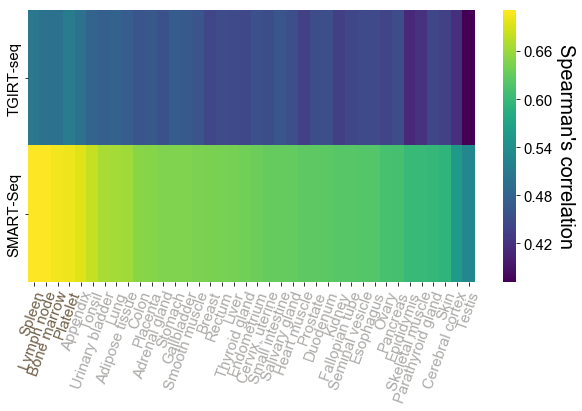

In [86]:
fig = plt.figure(figsize= (10,5))
ax = fig.add_subplot(111)
p = sns.heatmap(cor_df\
                .transpose()\
                .rename(index={'DNase I':'TGIRT-seq','Poly(A)-selected':'SMART-Seq'}), 
            ax = ax, cmap = 'viridis')
p.collections[0].colorbar.set_label("Spearman's correlation", 
                                    rotation = 270, va = 'bottom', fontsize=20)
yt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)
yt = ax.set_xticklabels(cor_df.index.str.capitalize().tolist(), rotation = 70, rotation_mode = 'anchor', ha ='right')
for yt in ax.get_xticklabels():
    if re.search('one marrow|ymph node|pleen|latelet', yt.get_text()):
        yt.set_color('#72624a')
    else:
        yt.set_color('#adaba9')
ax.set_yticks([0.5,1.5])
yt = ax.set_yticklabels(ax.get_yticklabels(), va='center')
fig.savefig(figure_path + '/kallisto_tissue_cor.png', bbox_inches='tight')

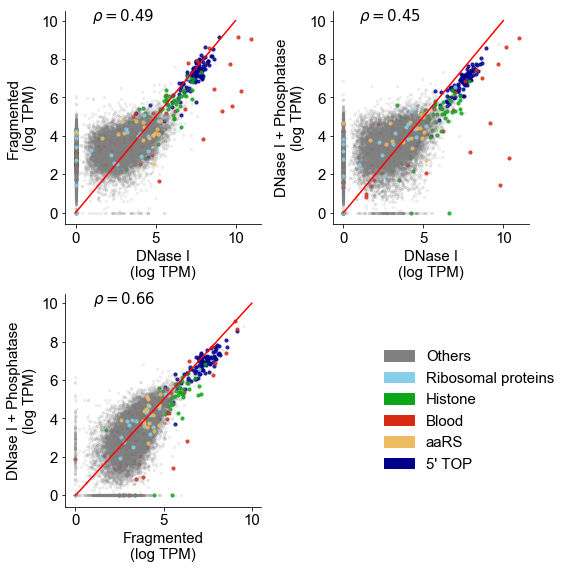

In [87]:
fig = plt.figure(figsize = (8,8))

for i, (xv, yv) in enumerate([('DNase I', 'Fragmented'), 
                            ('DNase I','DNase I + Phosphatase'),
                             ('Fragmented', 'DNase I + Phosphatase')]):
    ax = fig.add_subplot(2,2,i+1)  
    xs = np.array([])
    ys = np.array([])
    for (lab, color), sub_tpm in tpm_df.filter(['gname', xv, yv])\
            .assign(gene_lab = lambda d: d.gname.map(label_gene))\
            .assign(gene_lab = lambda d: np.where(d.gname.isin(TOP_RNA), "5' TOP", d.gene_lab))\
            .assign(color = lambda d: d.gene_lab.map(gene_encoder.encoder)) \
            .groupby(['gene_lab', 'color']):
        x = np.log(sub_tpm[xv] + 1)
        y = np.log(sub_tpm[yv] + 1)
        alpha = 0.1 if lab == "Others" else 0.8
        size = 5 if lab =='Others' else 10
        ax.scatter(x, y, color = color, alpha=alpha, s= size)
        xs = np.append(xs,x)
        ys = np.append(ys,y)
    ax.plot([0,10],[0,10], color='red')
    ax.set_xlabel(xv + '\n(log TPM)')
    ax.set_ylabel(yv + '\n(log TPM)')
    rho, p = spearmanr(xs, ys)
    ax.text(1, 10, r'$\rho = %.2f$' %rho, fontsize=15)
sns.despine()
ax = plt.subplot(224)
gene_encoder.show_legend(ax, bbox_to_anchor = (1.2,0.8), fontsize=15, frameon=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
fig.tight_layout()
fig.savefig(figure_path + '/kallisto_tgirt.png', bbox_inches='tight')

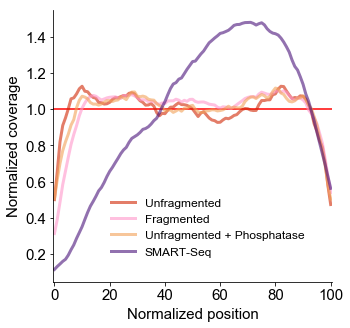

In [91]:
from sequencing_tools.viz_tools import RNA_cov_from_picard
metrics = glob.glob('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/kallisto_protein_result/bam_files/picard/*.RNAseq_metrics')
cov_df = RNA_cov_from_picard(metrics) \
    .assign(lab = lambda d: d.samplename.map(label_prep))
    

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for color, prep in zip(['#d12604', '#ff96cb', '#f2a157','#49127a'],
                      prep_order):
    plot_df = cov_df.query('lab == "%s"' %prep)
    ax.plot(plot_df['normalized_position'],
           plot_df['All_Reads.normalized_coverage'],
           color = color,
           label = prep,
           linewidth = 3, alpha=0.6)
ax.hlines(xmin = -5, xmax = 1000, color = 'red', y = 1)
ax.legend(title = '', fontsize=12, 
          bbox_to_anchor = (0.17,0.35), 
          frameon=False)
ax.set_xlim(-0.5,100.5)
ax.set_xlabel('Normalized position')
ax.set_ylabel('Normalized coverage')
sns.despine()
fig.savefig(figure_path + '/kallisto_coverage_plot.png', bbox_inches='tight')

In [89]:
salmon_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/kallisto_all_result'
sample_folders = glob.glob(salmon_path + '/Q*')
sample_folders.sort()
kallisto_tpm = list(map(lambda x: x + '/abundance.tsv', sample_folders))
tpm_dfs = map(read_kallisto, kallisto_tpm)
tpm_dfs = map(lambda d: d.drop(['eff_length'], axis=1), tpm_dfs)
tpm_df = reduce(lambda x,y: x.merge(y, how = 'outer', on = ['gname','gid']), tpm_dfs) \
    .pipe(pd.melt, id_vars = ['gname','gid'], var_name ='samplename', value_name = 'TPM') \
    .assign(prep = lambda d: d.samplename.map(label_sample)) \
    .groupby(['gname','gid','prep'], as_index=False)\
    .agg({'TPM': 'mean'}) \
    .assign(TPM = lambda d: d.groupby('prep')['TPM'].transform(lambda x: x/x.sum() * 1e6))\
    .pipe(pd.pivot_table, columns = 'prep', values='TPM', index=['gid','gname'], fill_value = 0)\
    .reset_index() \
    .assign(gid = lambda d: d.gid.str.split('.',expand=True).iloc[:,0])\
    .merge(genes_annot()\
            .rename(columns = {'Name':'gid'}),
        on = ['gid','gname'])
tpm_df.head()

,gid,gname,DNase I,DNase I + Exo I,DNase I + Phosphatase,Fragmented,Poly(A)-selected,gtype


In [90]:
tpm_df\
    .query('gtype == "protein_coding"')\
    .pipe(lambda d: d[~d.gname.str.contains('^RP')])\
    .sort_values('Poly(A)-selected', ascending=False)

,gid,gname,DNase I,DNase I + Exo I,DNase I + Phosphatase,Fragmented,Poly(A)-selected,gtype
